**CV2022 - week 7**

**CONTENTS**

* [Hough Transfom Lane detector](https://colab.research.google.com/drive/16NFlm2vpHoNUiQUoilDl4FxssB80Qpr3#scrollTo=2lVdNJaRdruR)
* [OpenCV SIFT](https://colab.research.google.com/drive/16NFlm2vpHoNUiQUoilDl4FxssB80Qpr3#scrollTo=CBMm55QZUZeW)
* [Fundamental matrix estimation](https://colab.research.google.com/drive/16NFlm2vpHoNUiQUoilDl4FxssB80Qpr3#scrollTo=i7tm_j-NME6-)
* [RANSAC](https://colab.research.google.com/drive/16NFlm2vpHoNUiQUoilDl4FxssB80Qpr3#scrollTo=Kwjmtxo2MDsK)


**HOMEWORK**

* **2bp** Using a KDTree object and *SIFT* descriptors extracted from both images, update the fundamental matrix demo to use the *mutual nearest neighbor* matching approach. 

* **1bp** Use RANSAC to fine the best linear regression fitting a set of randomly generated samples. Propose an exponential family metric to compute the difference to the model's prediction.  Analyse metrics response when varying it's parameters to be less/more sensitive to outliers. 

* **1bp** Update the RANSAC 8-points algorithm to adaptively determine the number of iterations with respect to the inliers ratio and the number of samples needed to fit the model. Explain your proposal.

**Hough Transform lane detector**

In this task, we are going to assess the possibility of implementing a stable lane detector using the Hough transform.

Additional pre-processing steps will be followed to produce a stable solution.

**References**
* [Input data and algorithm](https://github.com/Nushaine/lane-detection)

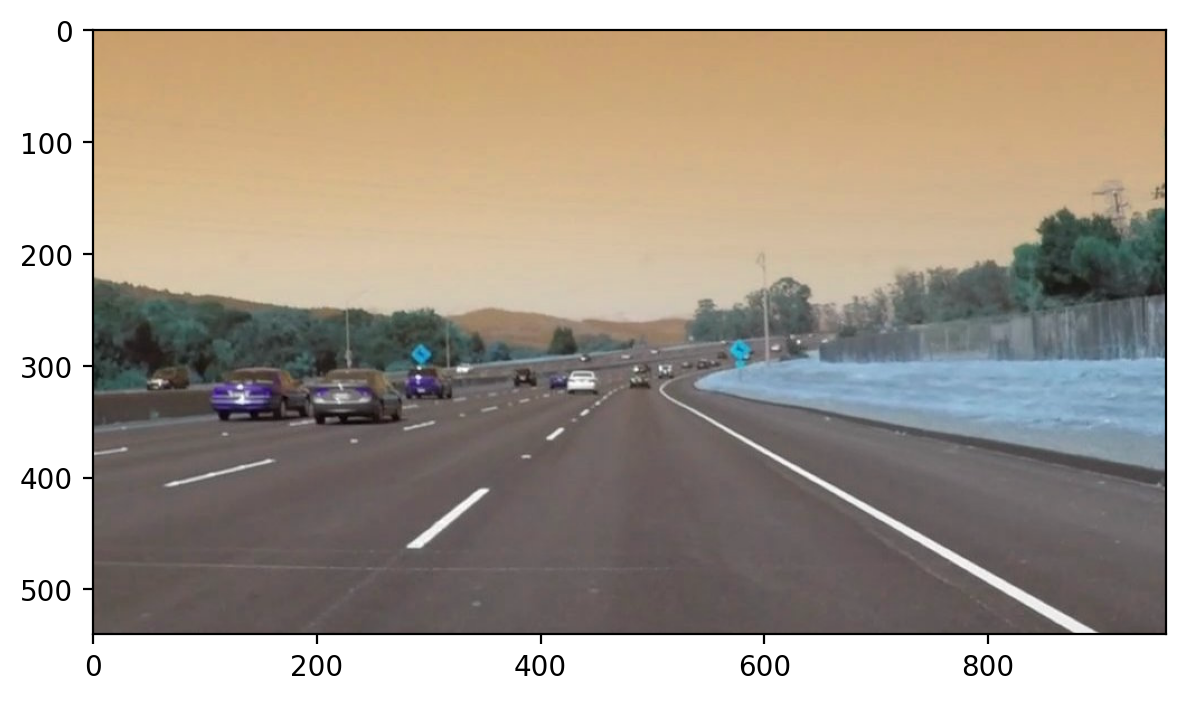

In [11]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200


curve_image = cv.imread("/Users/catalin/Documents/computer-vision/Labs7/curve.jpg")
plt.imshow(curve_image)

In [12]:
# now we will extract the focus region in shape of a triangle
def extract_region(image):
  h, w = image.shape
  tri = np.array([[(100, h), (475, 325), (w, h)]])
  mask = np.zeros_like(image)
  mask = cv.fillPoly(mask, tri, 255) # fit the polygon
  mask = cv.bitwise_and(image, mask) # suppress the information
  return mask


# dummy function for lanes plotting
def plot_image(image, lines):
  show_image = np.zeros_like(image)

  if lines is not None:
    for l in lines:
      x1, y1, x2, y2 = l
      cv.line(show_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
  
  return show_image

# compute points in the image to plot the lines
def compute_line_points(image, average_params):
  slope, elevation = average_params
  y1 = image.shape[0]
  y2 = int(y1 * (3/5))
  x1 = int((y1 - elevation) // slope)
  x2 = int((y2 - elevation) // slope)
  return np.array([x1, y1, x2, y2])


# determine the most probable line as the average of the lines in the focus region
def average_lines(image, lines):
  left_lines = []
  right_lines = []
  for  l in lines:
    x1, y1, x2, y2 = l.reshape(4) 
    line_params = np.polyfit((x1, x2), (y1, y2), 1)
    slope, elevation = line_params

    if slope < 0:
      # left side line
      left_lines.append((slope, elevation))
    else:
      right_lines.append((slope, elevation))

  left_average = np.average(left_lines, axis=0)
  right_average = np.average(right_lines, axis=0)

  left_line = compute_line_points(image, left_average)
  right_line = compute_line_points(image, right_average)
  return np.array([left_line, right_line])


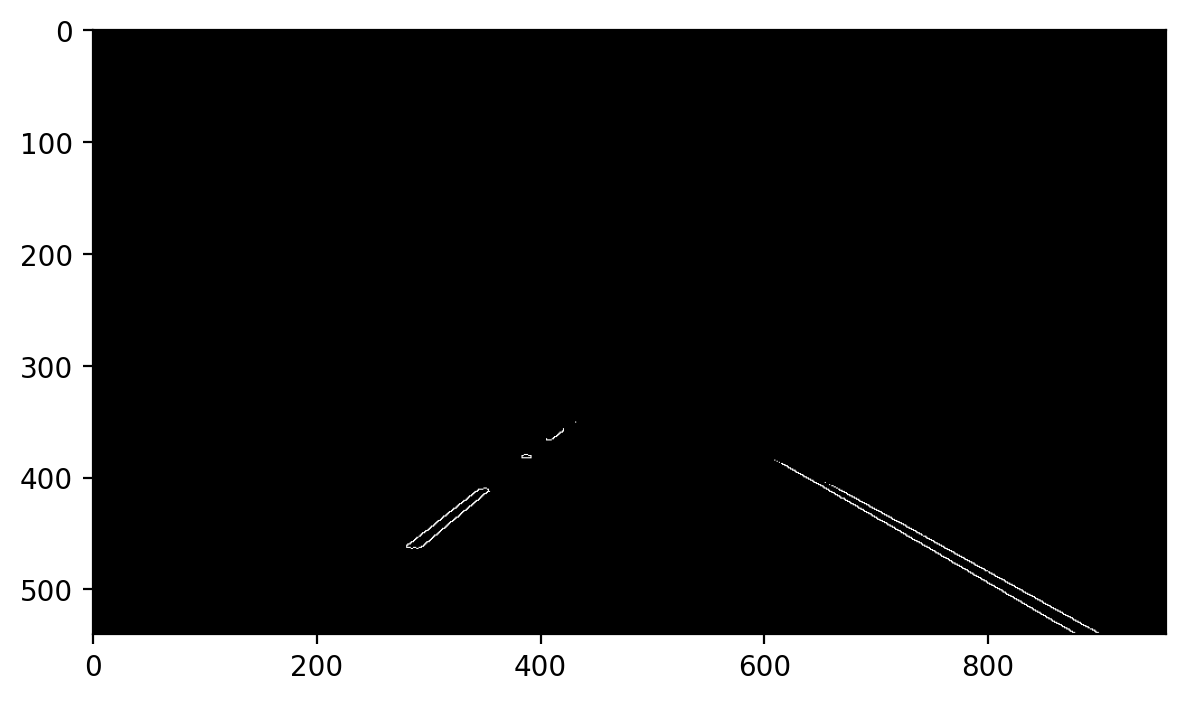

In [13]:
edges = cv.Canny(curve_image, 50, 150)
focus_region = extract_region(edges)
plt.imshow(focus_region, cmap='gray')

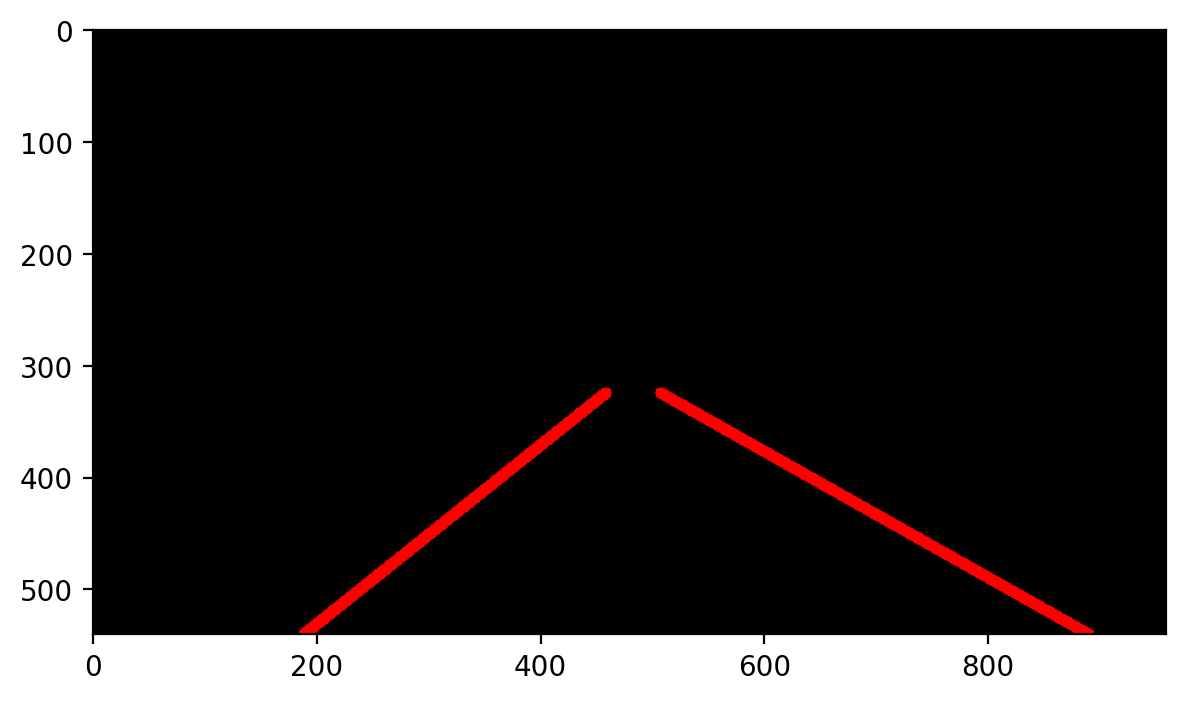

In [14]:
hough_lines = cv.HoughLinesP(focus_region, 2, np.pi/180, 100, np.array([]), minLineLength=4, maxLineGap=5)

average = average_lines(np.copy(curve_image), hough_lines)
display_image = plot_image(curve_image, average)
plt.imshow(display_image)

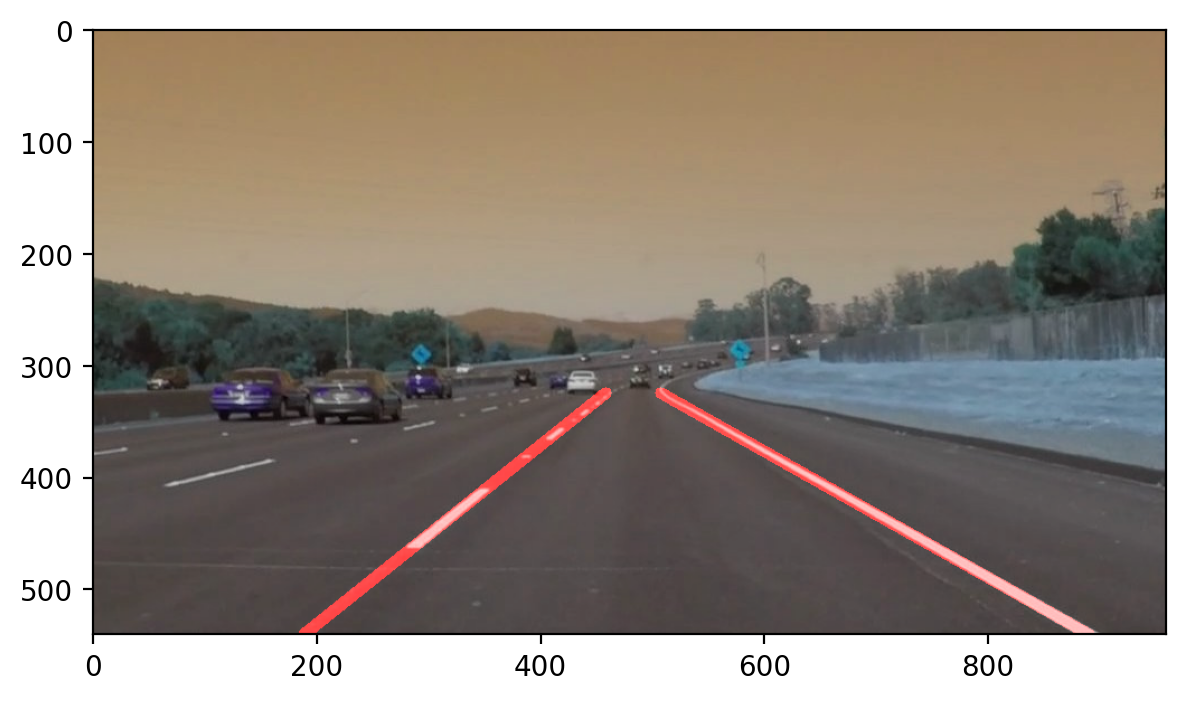

In [15]:
lanes = cv.addWeighted(np.copy(curve_image), 0.8, display_image, 1, 1)
plt.imshow( lanes)

**2. OpenCV SIFT**

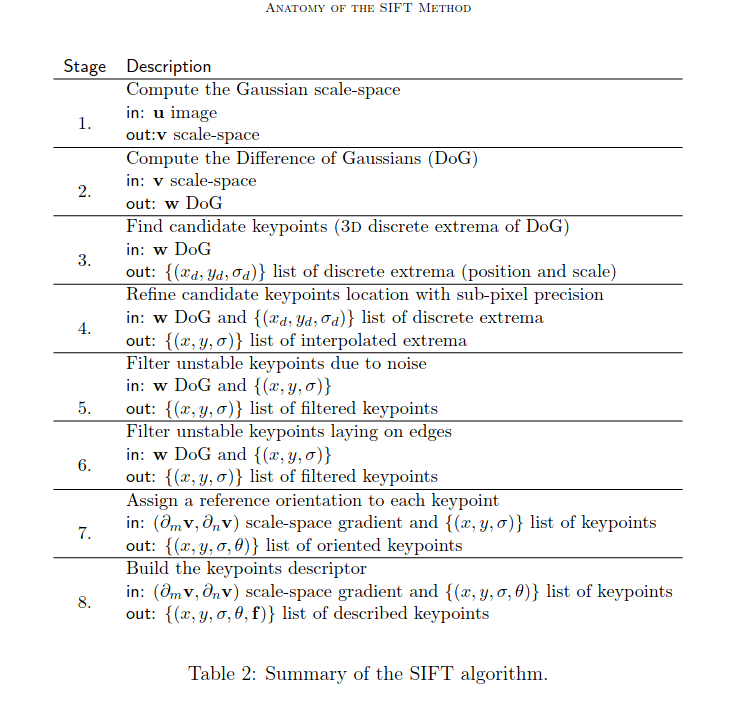

**Documentation**

* [SIFT pipeline](https://www.ipol.im/pub/art/2014/82/article_lr.pdf)
* [SIFT](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html)
* [Features matching](https://www.docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html)

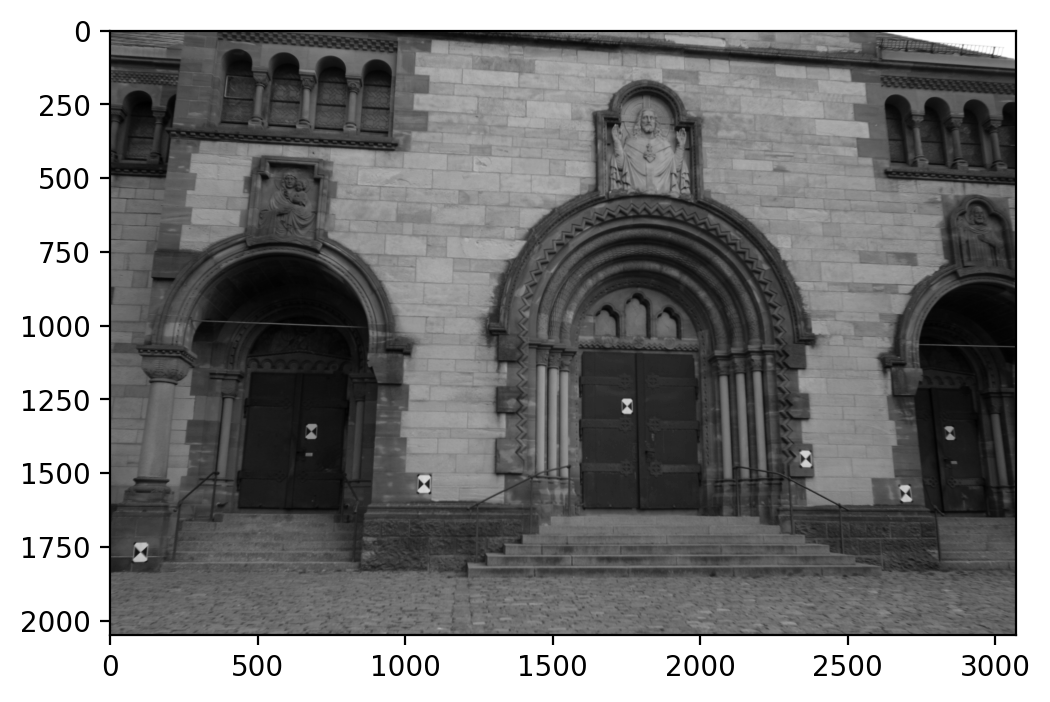

In [16]:
img_left = cv.imread("/Users/catalin/Documents/computer-vision/Labs7/0018.png")
img_left_gray = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
img_right = cv.imread("/Users/catalin/Documents/computer-vision/Labs7/0019.png")
img_right_gray = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)
plt.imshow(img_left_gray, cmap='gray')


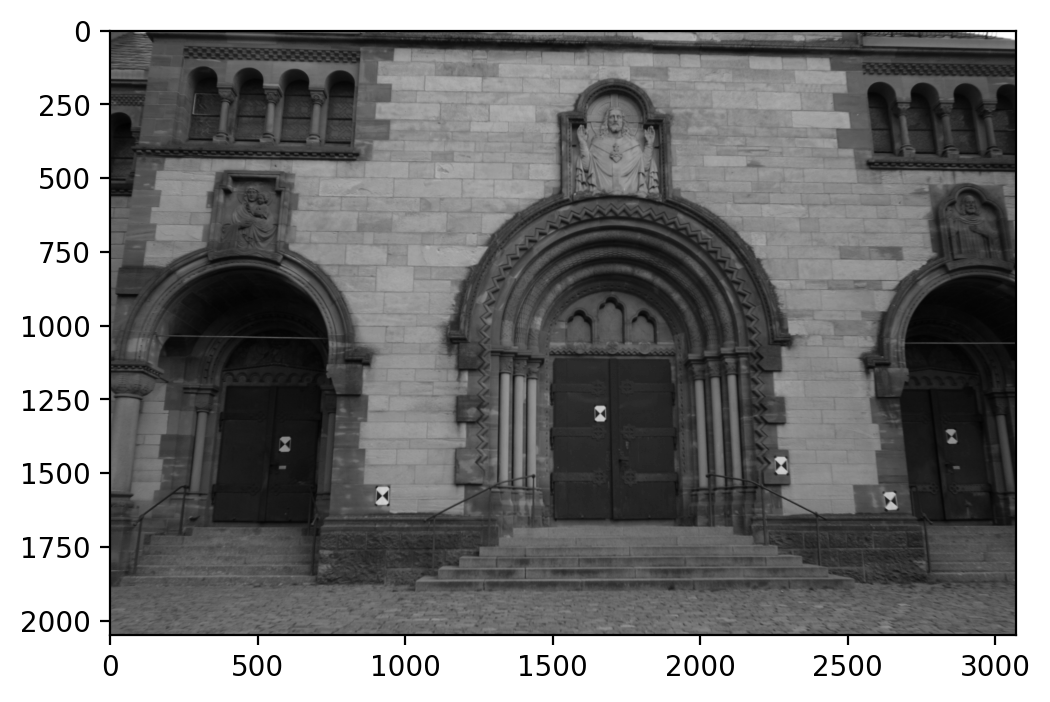

In [17]:
plt.imshow(img_right_gray, cmap='gray')

In [18]:
!pip install opencv-contrib-python==4.4.0.44

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==4.4.0.44 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64)
ERROR: No matching distribution found for opencv-contrib-python==4.4.0.44


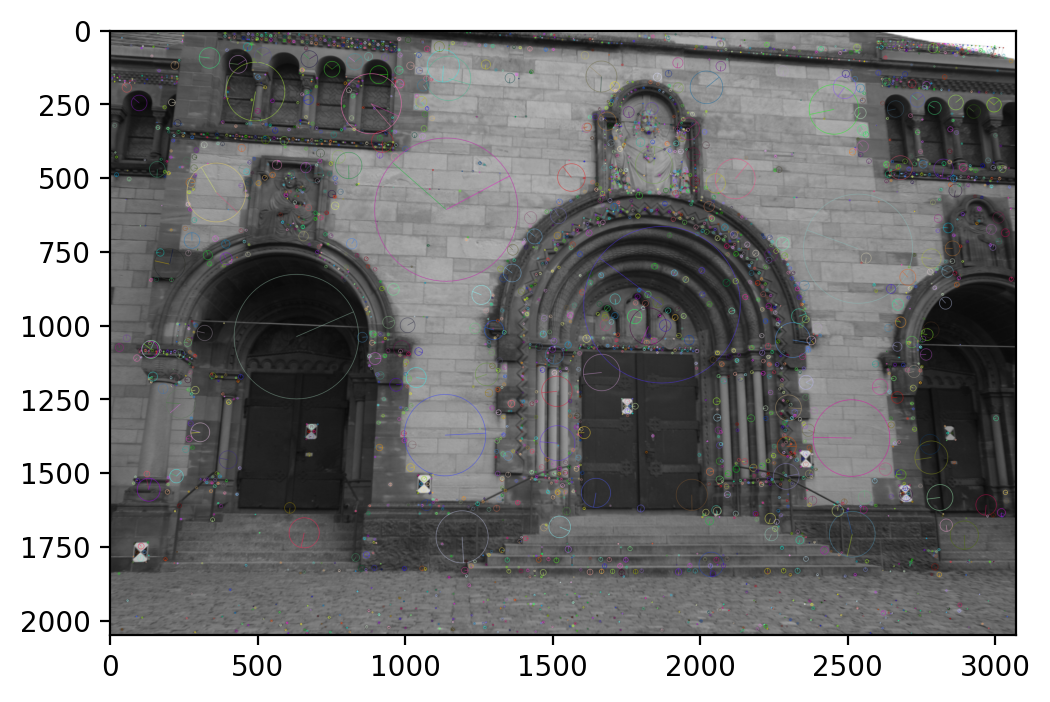

In [19]:
# because of the SIFT patent, an older version of opencv has to be installed
#!pip install opencv-contrib-python==4.4.0.44


# next, SIFT will be used to extract features from both images
sift = cv.SIFT_create()
kp_l, desc_l = sift.detectAndCompute(img_left_gray, None)
kp_r, desc_r = sift.detectAndCompute(img_right_gray, None)
desc_img_left = cv.drawKeypoints(img_left_gray, kp_l, img_left, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
desc_img_right = cv.drawKeypoints(img_right_gray, kp_r, img_right, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
plt.imshow(desc_img_left)

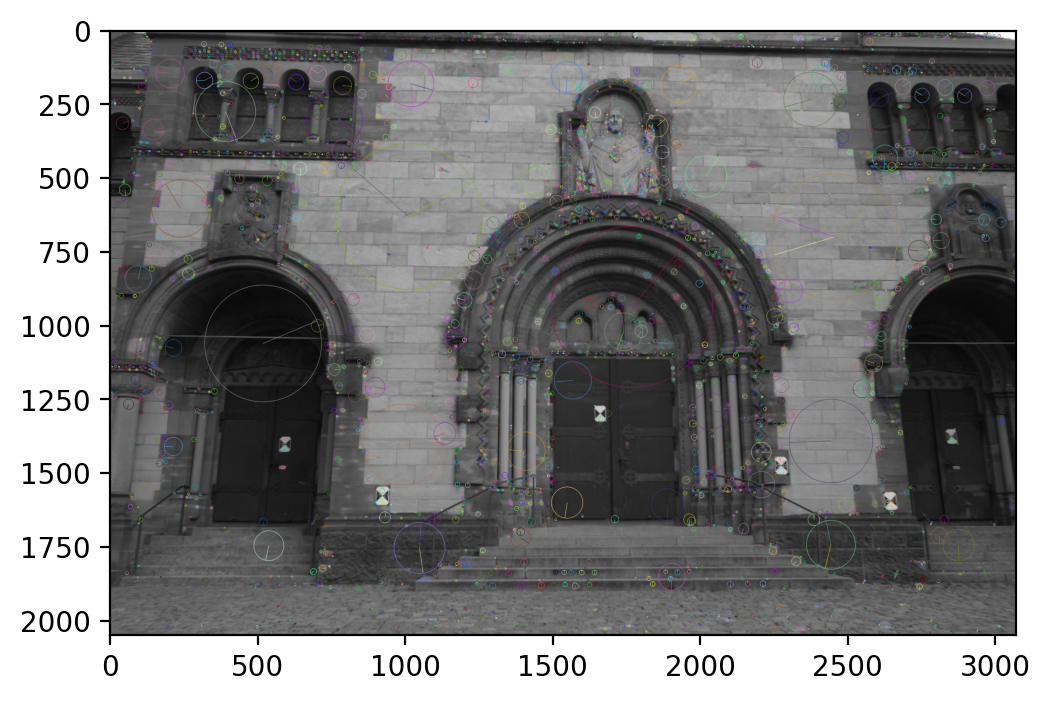

In [20]:
plt.imshow(desc_img_right)

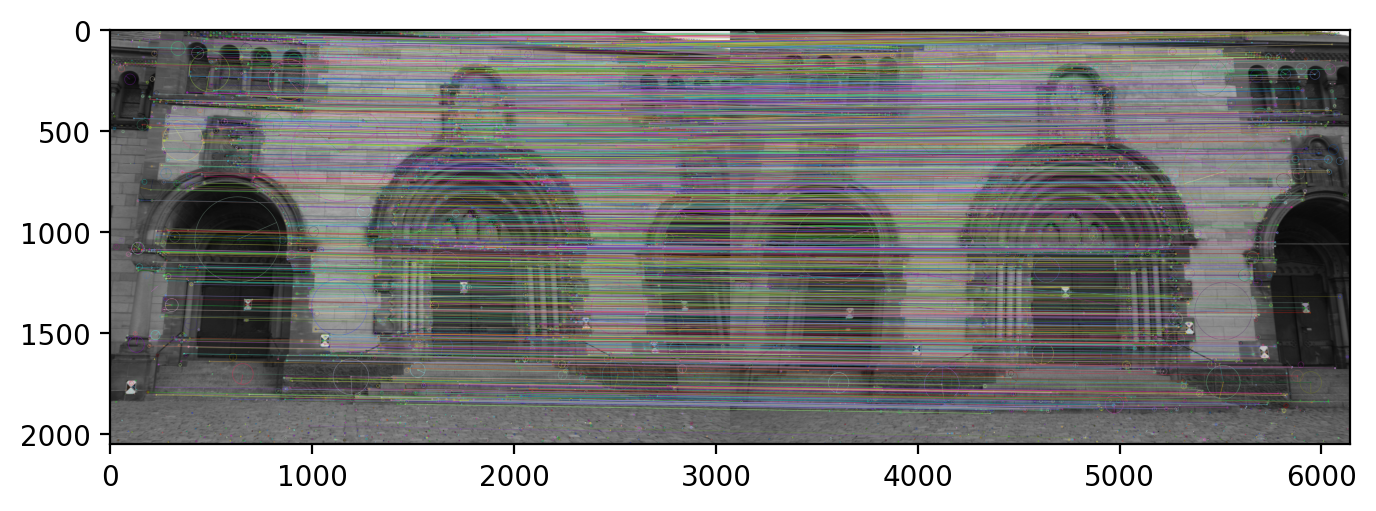

In [21]:
# next, the sets of feature descriptors are to be matched
bf_matcher = cv.BFMatcher()
matches = bf_matcher.knnMatch(desc_l, desc_r, k=2) # perform also a ratio test

kept_matches = []
for m, n in matches:
  if m.distance < 0.75 * n.distance:
    kept_matches.append([m]) # can't plot without the list []

# draw matches
img_matches = cv.drawMatchesKnn(img_left, kp_l,  img_right, kp_r, kept_matches,
                                None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)

In [22]:
# let's see how can we interpret the matches
for m in kept_matches[:5]:
  # remind about appending the match in a  list
  print(m[0].trainIdx) # index in des2
  print(m[0].queryIdx) # index in des1 
  print(m[0].distance) # distance

6
32
157.74346923828125
4
33
137.95651245117188
10
38
53.81449508666992
12
39
61.384037017822266
28
64
81.9695053100586



**3. Epipolar geometry and fundamental matrix**

The figure presented in this section represents the *stereo vision* setup. Two different cameras are used to capture the same object. The center posision of both camera is, evidently known. The line between the camera centers is called *baseline*, and it can be used to determine a 3D model of the observed object.
Each optical center projects in the other image as a point called *the epipole*. The epipole is characteristic to each of the images.

The *epipolar plane* is the plane spanned by a set of three points, the camera centers and the position of the observed point. The intersection between the epipolar plane and both image planes determines the *epipolar lines* in both images.  

Both cameras are characterized by their respective image plane. The lines between the observed point and each camera center are called *lines of sight*. 
As you can see, there exists a transformation between the left image representation and the right image representation. This transformation is called the *fundamental matrix*.

 If the line *P1-P3* is going to be matched, it will appear like a line in the *right image* and a point in the *left image*. So, the transformation is rank deficient.

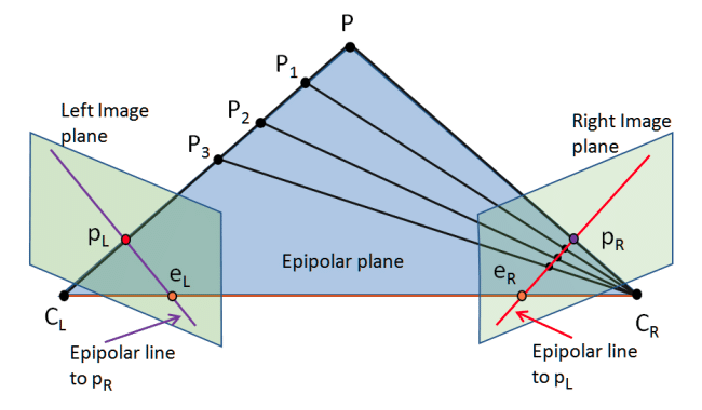


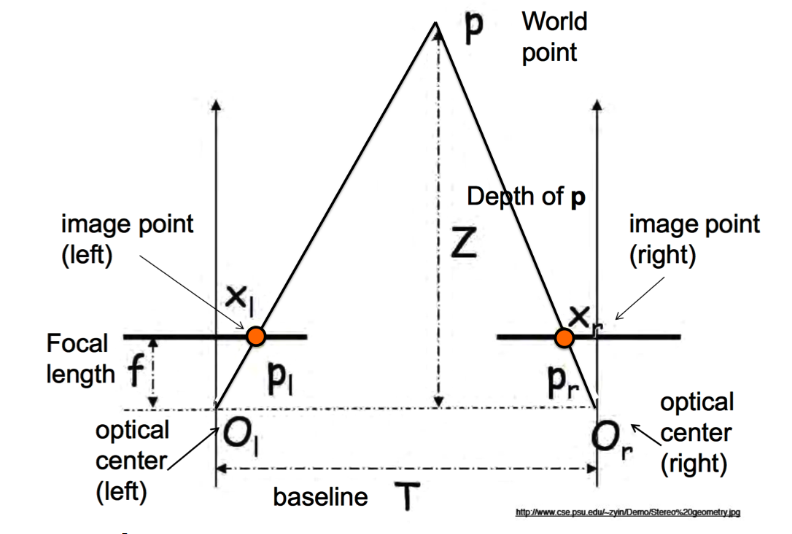

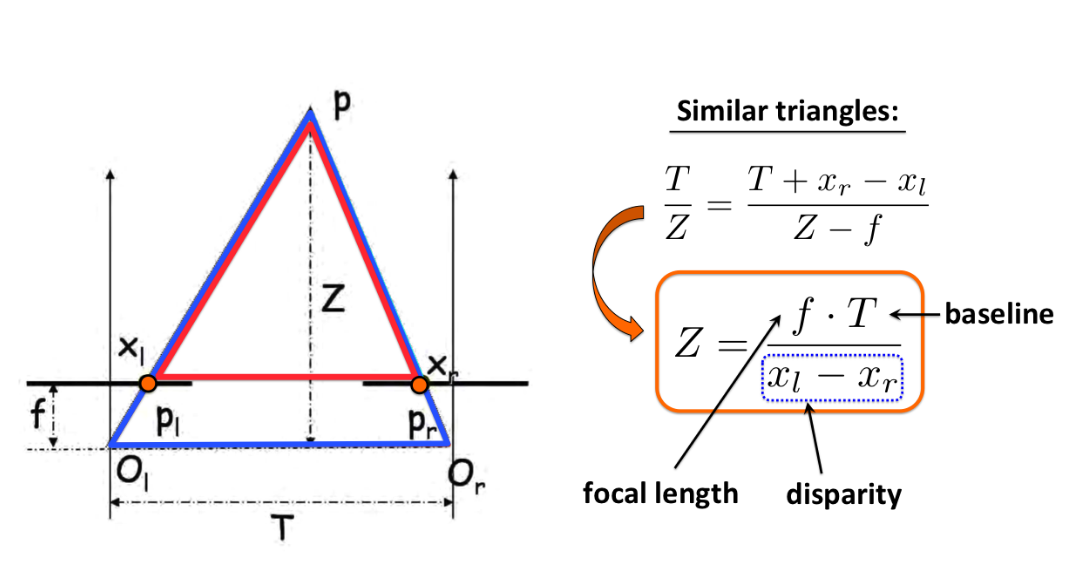


**References**

* [Stereo matching](http://www.cs.toronto.edu/~fidler/slides/2017/CSC420/lecture12_hres.pdf)

* Ingemar J. Cox, Sunita L. Hingorani, Satish B. Rao, Bruce M. Maggs,
A Maximum Likelihood Stereo Algorithm,
Computer Vision and Image Understanding,
Volume 63, Issue 3,
1996,
Pages 542-567,
ISSN 1077-3142,

* [URL for the article with the pseudocode](https://www.sciencedirect.com/science/article/pii/S1077314296900405?via%3Dihub)

* [Data Source](https://home.cvlab.cs.tsukuba.ac.jp/dataset)

**The Fundamental Matrix**

As we discussed last week, there exists a relationship between the *left image plane* and the *right image plane*. To define such a transformation, the next relationship between the point sets in both planes has to hold, since they are represented in both image planes.


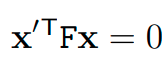

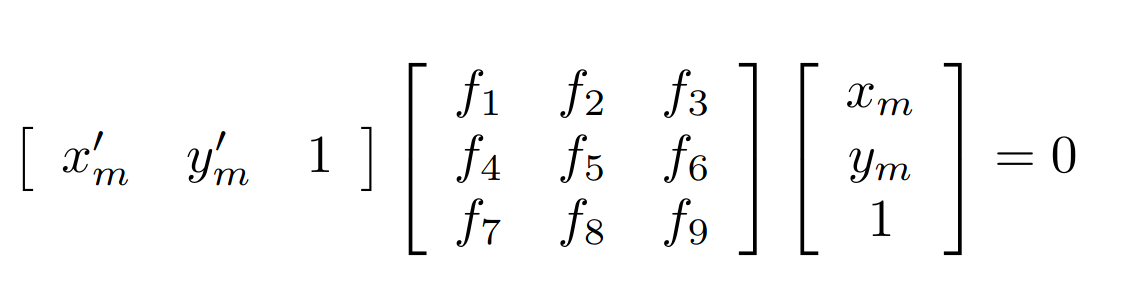

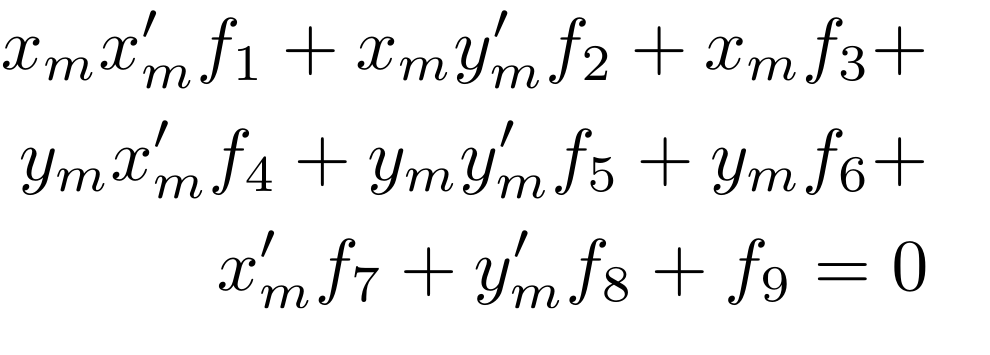

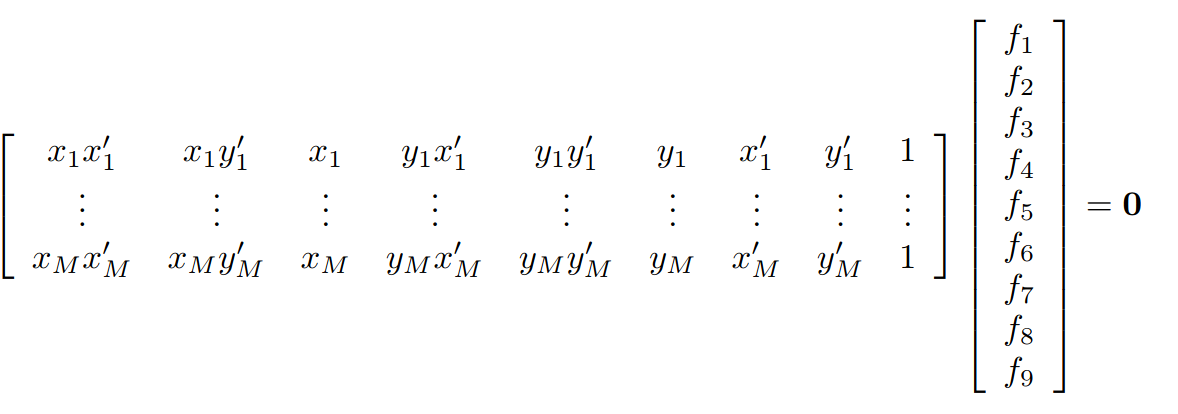

**References**
* [8-points algorithm derivation](http://www.cs.cmu.edu/~16385/s17/Slides/12.4_8Point_Algorithm.pdf)
* [About 8-points algorithm](https://courses.cs.duke.edu//fall15/compsci527/notes/longuet-higgins.pdf)
* [Epipolar geometry review](https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook2/HZepipolar.pdf)

In [23]:
# now we will prepare the arrays with the matched keypoints
x1s = np.ones((3, len(kept_matches)))
x2s = np.ones((3, len(kept_matches)))

print(len(kp_l), len(desc_l))
print(len(kp_r), len(desc_r))
print(len(kept_matches))

k = 0
for m in kept_matches:
  try:
    i_r = m[0].trainIdx
    i_l = m[0].queryIdx
    x1s[:2, k] = kp_l[i_l].pt
    x2s[:2, k] = kp_r[i_r].pt
    k += 1
  except IndexError:
    print((i_l, i_r))

print(x1s)
print(x2s)


3645 3645
3154 3154
1938
[[7.47381973e+01 7.52564774e+01 8.33854446e+01 ... 3.03490527e+03
  3.03490527e+03 3.04732568e+03]
 [1.66240311e+02 1.61934860e+02 1.75809113e+02 ... 4.62013367e+02
  4.62013367e+02 4.63747894e+02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
[[8.30010319e+00 7.88906240e+00 1.64056511e+01 ... 3.01743115e+03
  3.01743115e+03 3.03167651e+03]
 [2.41880981e+02 2.37633514e+02 2.50765762e+02 ... 4.15015167e+02
  4.15015167e+02 4.16105957e+02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


In [24]:
# now we can compute the fundamental matrix
# using the matrix form for the 8-points algo
# x and x_prime should be 3D x M homogeneouc coords array
# even if at least 8 eqs are needed, increasing the number of 
# equations will give a better stability for SVD

# firstly, the points have to be normalized for a stable SVD
# xs would be a 3d array with keypoints in homogeneous coords
def normalize_points(xs):
  _, n = xs.shape
  c = np.expand_dims(np.mean(xs[:2, :], axis=1), axis=1)
  d = xs[:2, :] - np.repeat(c, n, axis=1)
  d = np.sqrt(2) / np.mean(np.sqrt(np.sum(d * d, axis=0)))
  T = np.eye(3)
  T[0, 0] = d
  T[1, 1] = d
  T[0, 2] = -d * c[0]
  T[1, 2] = -d * c[1]
  normalized_xs = T @ xs
  return normalized_xs, T

# compute the fundamental matrix using the normalized data
def compute_fundamental_matrix(x, x_prime):
  _, n = x.shape
  A = np.zeros((n, 9))
  for i in range(n):
    A[i, 0] = x[0, i] * x_prime[0, i]
    A[i, 1] = x[0, i] * x_prime[1, i]
    A[i, 2] = x[0, i]
    A[i, 3] = x[1, i] * x_prime[0, i]
    A[i, 4] = x[1, i] * x_prime[1, i]
    A[i, 5] = x[1, i]
    A[i, 6] = x_prime[0, i]
    A[i, 7] = x_prime[1, i]
    A[i, 8] = 1
  
  A = A.T @ A
  U, S, V = np.linalg.svd(A, full_matrices=True)
  V = V.T
  F = V[:, -1]
  F = F.reshape(3, 3)

  # apply the rank constraint
  U_f, S_f, V_f = np.linalg.svd(F)
  S_f = np.diag(S_f)
  S_f[2, 2] = 0
  F_h = U_f @ S_f @ V_f
  return F_h, F




In [25]:
nxs_1, T1 = normalize_points(x1s)
nxs_2, T2 = normalize_points(x2s)

F_h, F = compute_fundamental_matrix(nxs_1, nxs_2)

# un-normalize Fh
F = T2.T @ F_h @ T1
print(F)

[[ 2.58220505e-09  1.11402032e-07 -1.11261285e-04]
 [-1.40914501e-07 -1.15072685e-08 -9.22998459e-04]
 [ 1.62436270e-04  1.03437334e-03 -1.13108846e-01]]


In [26]:
import random

_, n = x1s.shape

# plot 5 epipolar lines
idx = random.sample(range(n), 5)
X = x1s[:, idx]

lines = F @ X

# normalize to homogeneous coords
for i in range(5):
  lines[:, i] = 1 / lines[2, i] * lines[:, i] 
print(lines)



[[ 3.62581521e-05 -5.70684099e-06  2.47879616e-05 -6.91271331e-05
   4.84960879e-05]
 [-6.77566056e-04 -1.06903397e-03 -7.84565038e-04 -1.66064635e-03
  -5.63405208e-04]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]]


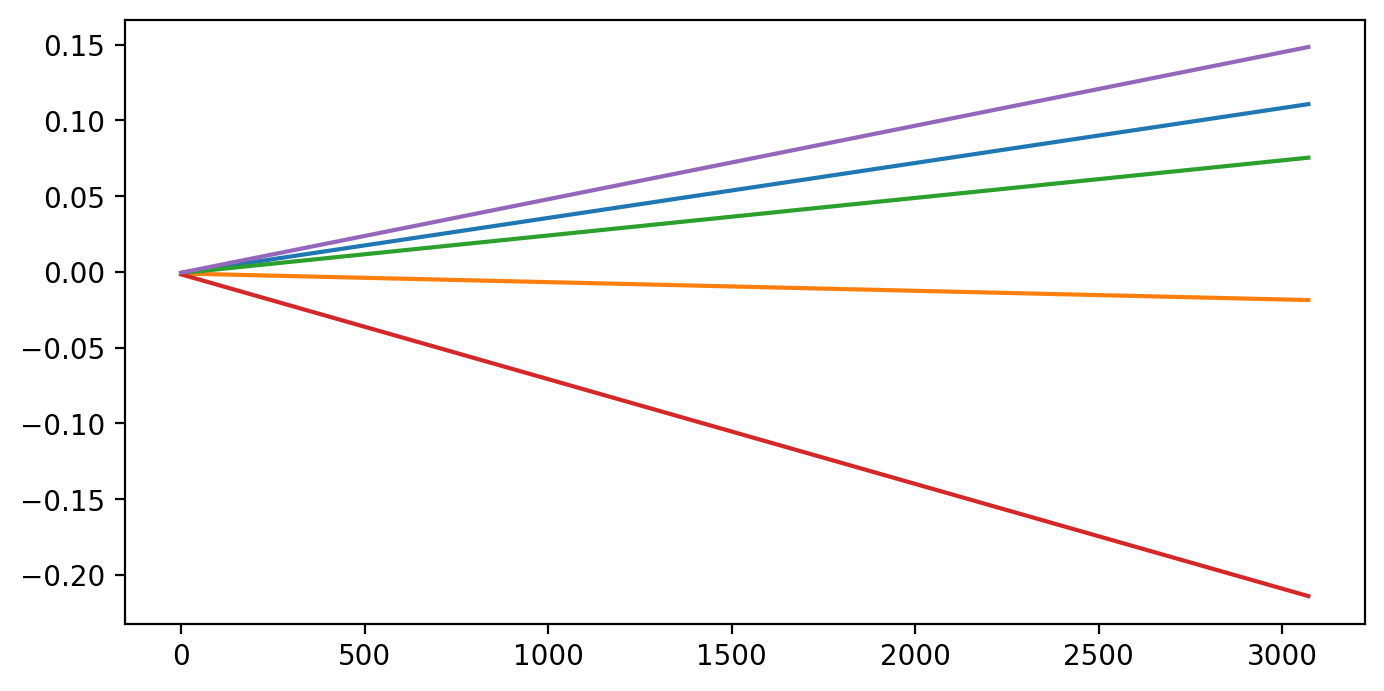

In [27]:
#plt.imshow(img_right)
h, w, _ = img_right.shape

for i in range(5):
  x = np.arange(w)
  y = lines[0, i] * x + lines[1, i]
  plt.plot(x, y)


**4.RANSAC**

*RANSAC* is an algorithm based on randomly sampling the data, in order to find a refinement over the model used to fit the input data.

When fitting the input data by a model, the prior ovet the model's parameters is a hypothesis that has to be tested. Optimizations over the parameters are built around the principle of the *Most Probable Explanation*. So, the data can be classified as an inlier (reasonable position according to the model), and outlier (significant difference between the input sample and the model prediction). The significance of outliers effect when fitting a particulaar model is an open topic, models robust to data noise being designed and improved. 

RANSAC approaches the method differently, continously sampling from the set of inliers, in order to reduce the effect of the outliers, in the final proposed model. 

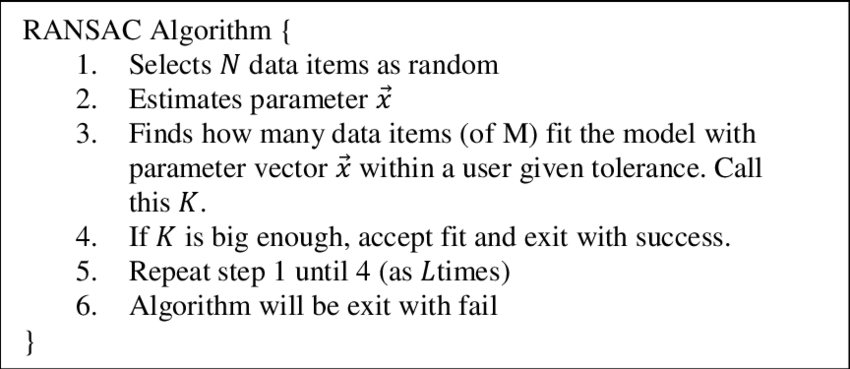

**References**

* [RANSAC 8-point alg.](https://ww2.mathworks.cn/help/vision/ref/estimatefundamentalmatrix.html#d123e164615)

* [About RANSAC](https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html)

In [28]:
# firstly, we have to define a reprojection error metric
def sampson_error(F, x1s, x2s):
  _, n = x1s.shape
  x1_reprojected = F @ x1s
  x2_reprojected = F.T @ x2s

  normalizer = np.dot(x1_reprojected[0, :], x1_reprojected[0, :]) + \
                np.dot(x1_reprojected[1, :], x1_reprojected[1, :]) + \
                np.dot(x2_reprojected[0, :], x2_reprojected[0, :]) + \
                np.dot(x2_reprojected[1, :], x2_reprojected[1, :])

  dist = np.zeros(n)
  for i in range(n):
    dist[i] = x2s[:, i].T @ F @ x1s[:, i]

  error = np.divide(dist ** 2, normalizer)
  return error


In [29]:
print(sampson_error(F_h, nxs_1, nxs_2))

[1.24925403e-05 1.25514193e-05 1.21861238e-05 ... 9.80415859e-06
 9.80415859e-06 1.00236567e-05]


In [30]:
def RANSAC_fundamental_matrix(x1s, x2s):
  _, n = x1s.shape
  d = 5e-6
  best_inliers = None
  best_inliers_nr = 0

  for k in range(1000):
    idx = random.sample(range(n), 8)
    x = x1s[:, idx]
    x_prime = x2s[:, idx]
    Fh, F = compute_fundamental_matrix(x, x_prime)
    error = sampson_error(Fh, x1s, x2s)
    inliers_idx = np.argwhere(error < d)
    nb_inliers = inliers_idx.shape[0]

    if nb_inliers > best_inliers_nr:
      best_inliers_nr = nb_inliers
      best_inliers = inliers_idx

  print(x1s[:, best_inliers].shape)
  Fh, F = compute_fundamental_matrix(x1s[:, best_inliers][:, :, 0], x2s[:, best_inliers][:, :, 0])
  return Fh, F


In [31]:
Fh, F = RANSAC_fundamental_matrix(nxs_1, nxs_2)
F = T2.T @ F @ T1
print(F) 

(3, 1914, 1)
[[-2.16215297e-09 -4.37789739e-07  7.47422453e-04]
 [ 4.07156827e-07 -6.50691025e-09 -1.73558233e-03]
 [-6.98606077e-04  1.79237764e-03 -2.29742563e-02]]


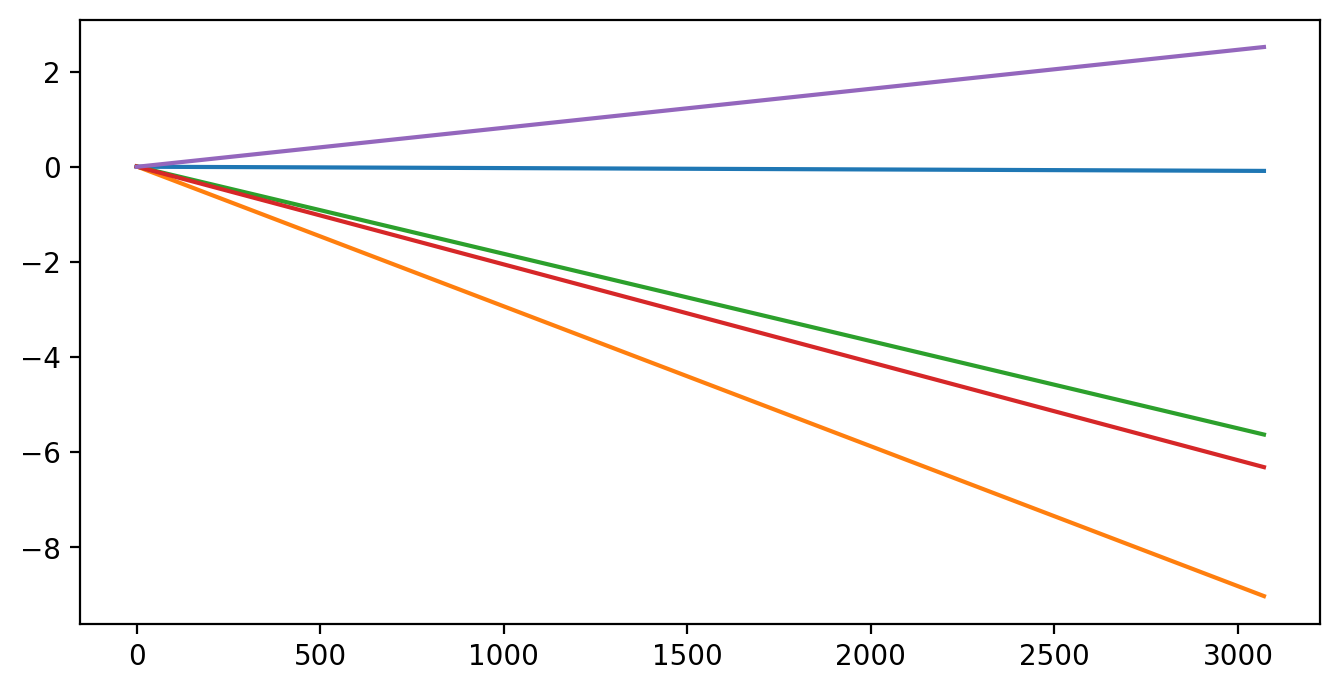

In [32]:
_, n = x1s.shape
idx = random.sample(range(n), 5)
X = x1s[:, idx]
lines = F @ X

for i in range(5):
  lines[:, i] = 1 / lines[2, i] * lines[:, i] 

h, w, _ = img_right.shape

for i in range(5):
  x = np.arange(w)
  y = lines[0, i] * x + lines[1, i]
  plt.plot(x, y)


**Additional resources**

* [Computer Vision: Algorithms and Applications 2](https://drive.google.com/file/d/1Siqtny2TCVxkA3K3h_59DRwZcPW0zHaZ/view?fbclid=IwAR3YofBLvqgZkfVS2IQk8mTTbQlJCg0C7LK5BgSF-PDf_EgPwKli3j6q7YQ)